# CSC3831 Final Assessment - Part I: Data Engineering



       median_house_value  median_income  housing_median_age   total_rooms  \
count        20640.000000   18576.000000        18576.000000  20640.000000   
mean        206855.816909       3.929958           28.324182   2635.763081   
std         115395.615874       1.964296           12.584914   2181.615252   
min          14999.000000       0.499900            1.000000      2.000000   
25%         119600.000000       2.560300           18.000000   1447.750000   
50%         179700.000000       3.572400           28.000000   2127.000000   
75%         264725.000000       4.870050           37.000000   3148.000000   
max         500001.000000      15.000100           52.000000  39320.000000   

       total_bedrooms    population    households      latitude     longitude  
count    20640.000000  18576.000000  20640.000000  20640.000000  20640.000000  
mean       537.898014   1488.069283    499.539680     35.631861   -119.569704  
std        421.247906   1170.585810    382.329753      2.

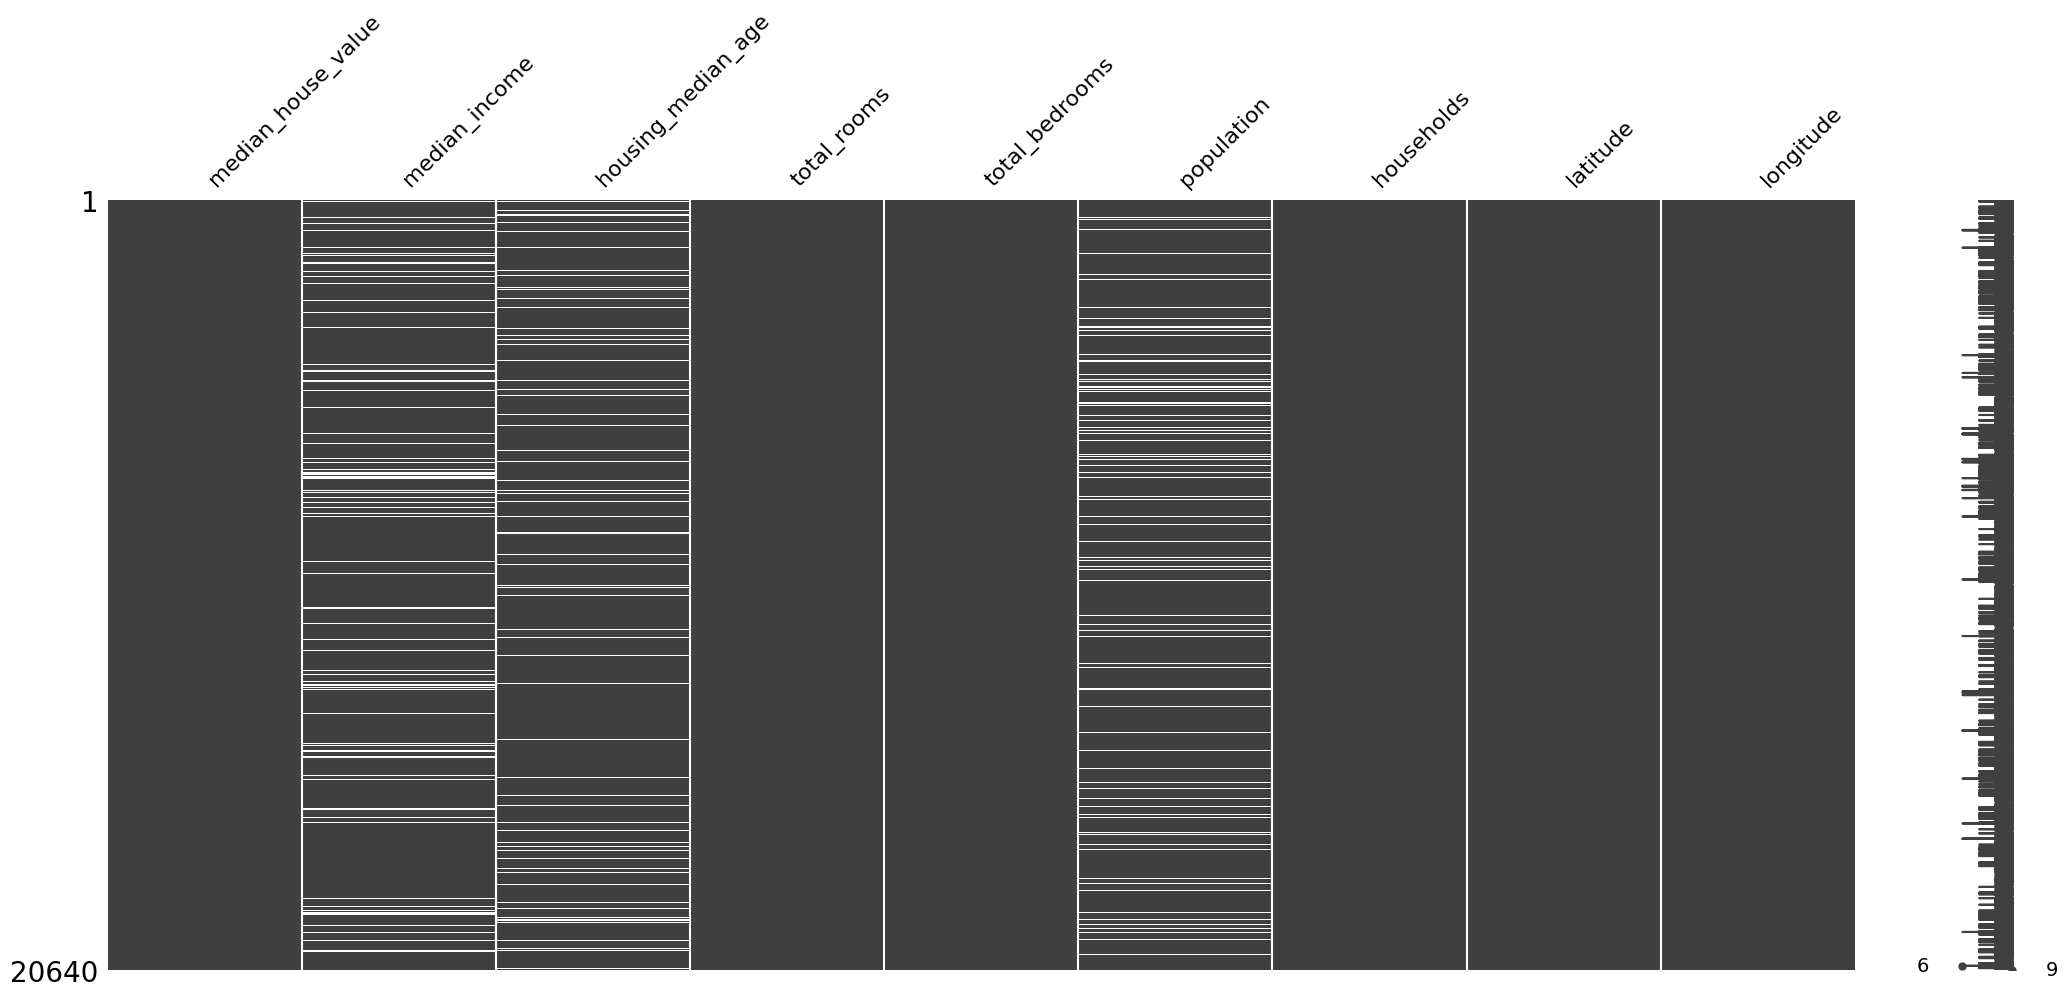

In [1]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np

# Loading in the corrupted dataset to be used in analysis and imputation
houses_corrupted = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv', header=0)
# Remove an artifact from the dataset
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)

# Vérifier les valeurs manquantes
msno.matrix(houses_corrupted)
# plt.show()

# Statistiques descriptives
print(houses_corrupted.describe(include='all'))




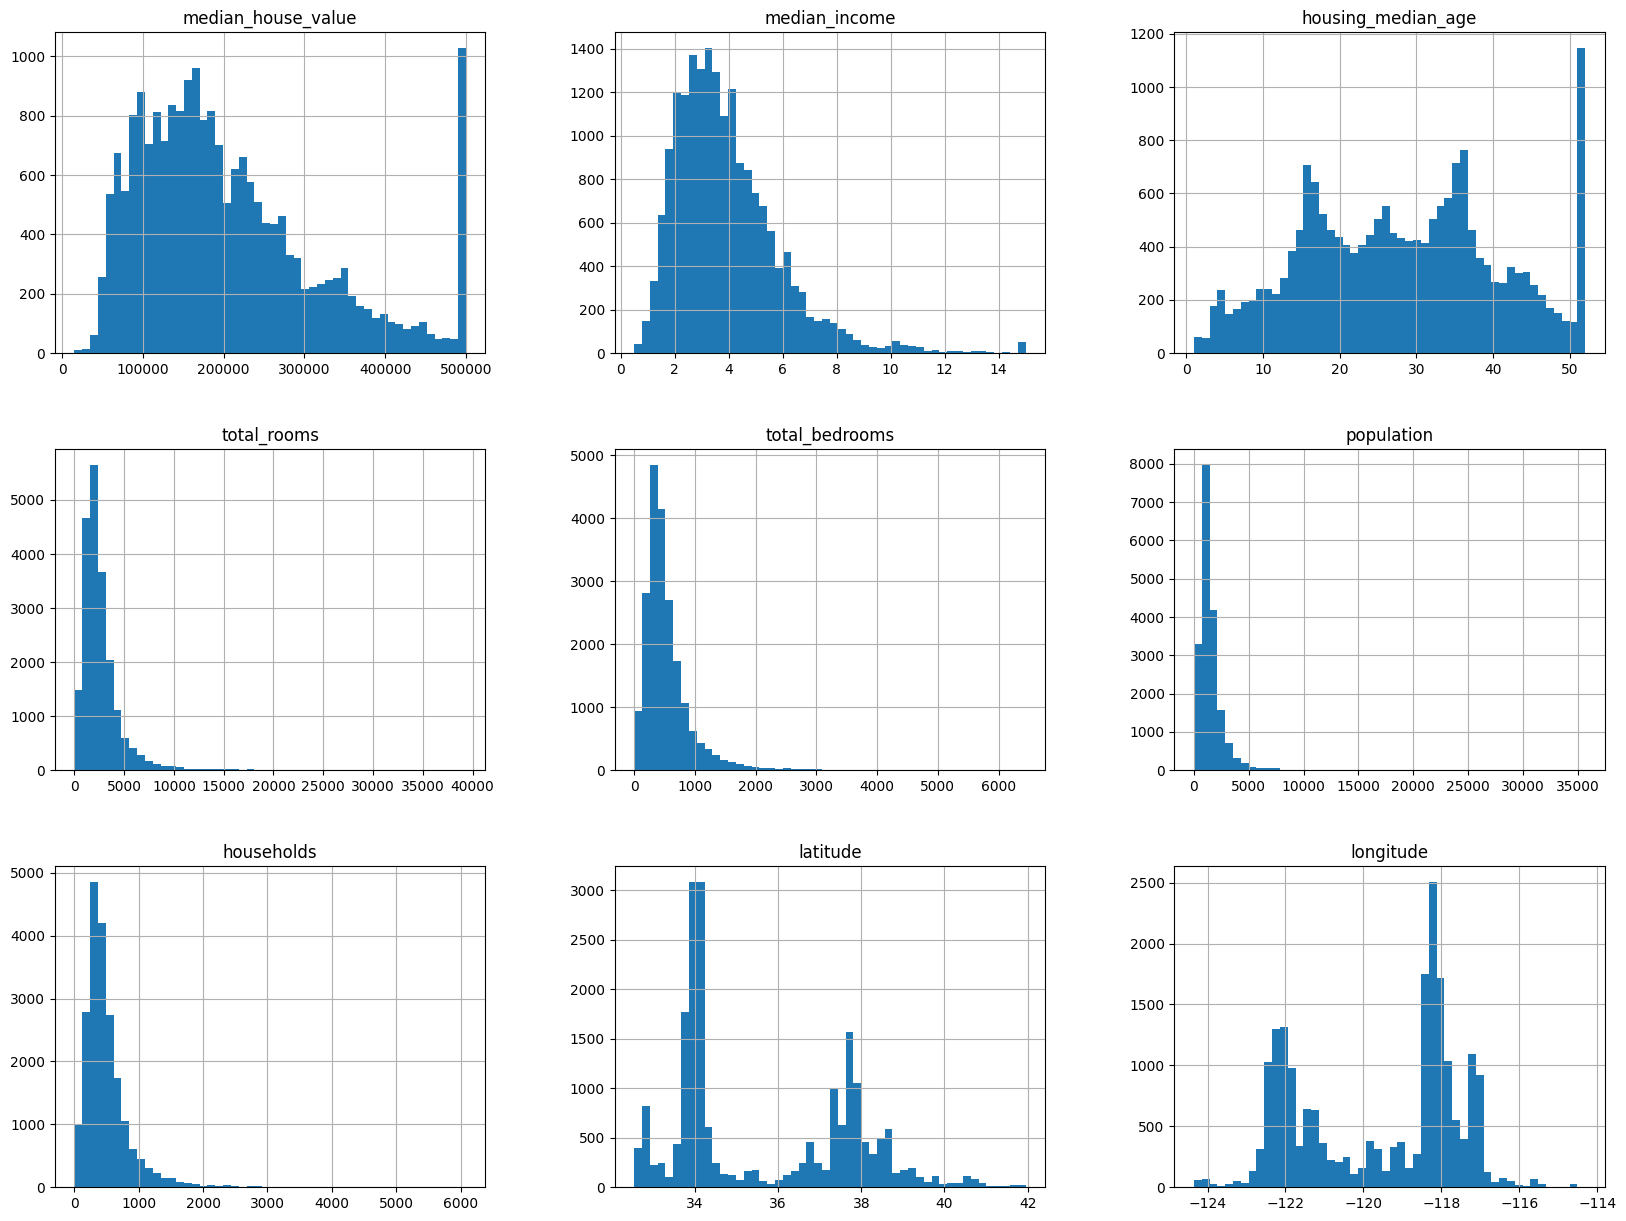

In [10]:
houses_corrupted.hist(bins=50, figsize=(20, 15))
plt.show()

Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]
- Perform ad hoc EDA to understand and describe what you see in the raw dataset
  - Include graphs, statistics, and written descritpions as appropriate
  - Any extra information about the data you can provide here is useful, think about performing an analysis (ED**A**), what would you find interesting or useful?
- Identify features with missing records, outlier records


In [ ]:
# FOLLOW THE LECTURE SLIDES 


# check the strings in the dataset to spot any malformatted strings

# histogram for attributes over others, describe the distribution of the data, the skewness, the outliers, etc.

# skew : if data is skewed : 
""" Log transforms: Taking the log of values
• Normalise: Force values between -1 and 1 or 0 and 1
• X-root: Taking the x-root of values (e.g. square-root, cube-root,
etc.)
• Remove outliers: May remove tail completely
 """

# Pairs Plot

#  barplot for outliers 

#  heatmap for missing values

# corr matrix

# Median Absolute Deviation (𝑀𝐴𝐷)
""" iris_MAD = pd.DataFrame(columns = iris.columns[:-1])
mads = []
for attribute in iris.columns[:-1]:
  mad = 1.483 * abs(iris[attribute] - iris[attribute].median()).median()
  """

# values_counts for categorical variables



# 1. Are there any relationships between the
# attributes in our data?
# 2. Is there any different in the attribution
# relationships when considering education
# level?
# 3. Which education level is consistent with a
# desired state of possessing housing and
# employment?
houses_corrupted.info()

# latitude over longitude plot
# plt.figure(figsize=(10, 10))
# plt.scatter(houses_corrupted['latitude'], houses_corrupted['longitude'])

# houses_corrupted.hist(bins=50, figsize=(20, 15))

# a plot to identifiy missing records 
# plt.figure(figsize=(10, 10))
# sns.heatmap(houses_corrupted.isnull(), cbar=False)

# a plot to identify outliers 
plt.figure(figsize=(10, 10))
sns.boxplot(data=houses_corrupted)

# plt.show()

# a plot to identify the correlation between the features
plt.figure(figsize=(10, 10))
sns.heatmap(houses_corrupted.corr(), annot=True)


### 2. Outlier Identification [10]
- Utilise a statistical outlier detection approach (i.e., **no** KNN, LOF, 1Class SVM)
- Utilise an algorithmic outlier detection method of your choice
- Compare results and decide what to do with identified outleirs
  - Include graphs, statistics, and written descriptions as appropriate
- Explain what you are doing, and why your analysis is appropriate
- Comment on benefits/detriments of statistical and algorithmic outlier detection approaches


In [ ]:

# Missing at Random (MAR) is data where there may be a systemic
# reason why some of the data is missing, but this knowledge does
# not help us with imputation

# Rare: Appear with low frequency relative to the rest of the data (inliers)
# • Unusual: Do not fit the data distribution
    


# - Utilise a statistical outlier detection approach (i.e., **no** KNN, LOF, 1Class SVM)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy import stats
from sklearn.impute import SimpleImputer

z_scores = np.abs(stats.zscore(houses_corrupted))
threshold = 3
statistical_outliers = (z_scores > threshold)

imputer = SimpleImputer(strategy='mean')
houses_imputed = imputer.fit_transform(houses_corrupted)

isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_forest.fit(houses_imputed)
algorithmic_outliers = isolation_forest.predict(houses_imputed) == -1

statistical_outliers_count = np.sum(statistical_outliers, axis=0)
algorithmic_outliers_count = np.sum(algorithmic_outliers)

print("Statistical Outliers Count per Feature:", statistical_outliers_count)
print("Algorithmic Outliers Count:", algorithmic_outliers_count)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=houses_corrupted)
plt.title('Box Plot of Features (Statistical Outliers)')

plt.subplot(1, 2, 2)
plt.scatter(houses_corrupted[:, 0], houses_corrupted[:, 1], c='red', label='Inliers')
plt.scatter(houses_corrupted[algorithmic_outliers, 0], houses_corrupted[algorithmic_outliers, 1], c='red', label='Outliers')
plt.title('Scatter Plot with Algorithmic Outliers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Step 5: Explain and Comment
print("""
Explanation:
- Statistical outlier detection using Z-score identifies outliers based on the standard deviation from the mean.
- Algorithmic outlier detection using Isolation Forest identifies outliers by isolating observations in the feature space.

Benefits and Detriments:
- Statistical methods are simple and easy to implement but may not capture complex outlier patterns.
- Algorithmic methods like Isolation Forest can capture complex patterns but may require more computational resources and careful tuning.
""")


### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


In [ ]:
# Use this dataset for comparison against the imputed datasets
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)

### 4. Conclusions & Throughts [3]
- Disucss methods used for anomaly detection, pros/cons of each method
- Disucss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation